# Two Layer Classifier
In this notebook, we will train a classifier with one hidden layer.
The loss function is calculated using the Softmax classifier loss
- compute the Softmax loss;
- obtain the patial derivative of each each weight;
- learning rate decay 
- optimization using SGD

## Basic settings

In [1]:
# Import the esential libs
import numpy as np
import random
import sys
import matplotlib.pyplot as plt

from cs231n.data_utils import load_CIFAR10

In [2]:
# set the matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# optional setting
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

## Cifar-10 Data loading and preprocessing

In [3]:
# Load the raw CIFAR-10 data.
X_tr, y_tr, X_te, y_te = load_CIFAR10('D:/CS231N_CNN/DataSet/cifar-10-batches-py/')
# As a sanity check, we print out the size of the traning ans test data
print('Training data shape:   ', X_tr.shape)
print('Training labels shape: ', y_tr.shape)
print('Test data shape:       ', X_te.shape)
print('Test labels shape:     ', y_te.shape) 

D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_1
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_2
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_3
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_4
D:/CS231N_CNN/DataSet/cifar-10-batches-py/data_batch_5
Training data shape:    (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:        (10000, 32, 32, 3)
Test labels shape:      (10000,)


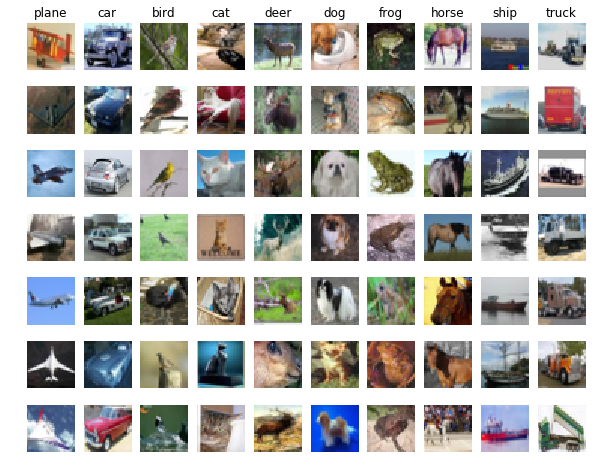

In [4]:
# visualize some examples from the dataset
# We show a few examples of trainging images from each class
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_tr == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_tr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)


plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 29000
num_validation = 1000
num_test = 1000

# Subsample the data
mask = range(num_training, num_training+num_validation)
X_val = X_tr[mask]
y_val = y_tr[mask]
mask = range(num_training)
X_train = X_tr[mask]
y_train = y_tr[mask]
mask = range(num_test)
X_test = X_te[mask]
y_test = y_te[mask]

# Normalise the data: subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# Reshape data to rows
X_train = X_train.reshape(num_training, -1)
X_val = X_val.reshape(num_validation, -1)
X_test = X_test.reshape(num_test, -1)

print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Train data shape: (29000, 3072)
Train labels shape: (29000,)
Validation data shape: (1000, 3072)
Validation labels shape: (1000,)
Test data shape: (1000, 3072)
Test labels shape: (1000,)


## A Two-Layer Network
in this section, we wll train a classifier with two layers (one hidden layer)

(1) ** Network structure**

A two-layer fully-connected neural network is built. The net has an input vector whose dimension is $D$, a hidden layer dimension of $H$, and performs classification over $C$ classes. We train the network with a **softmax loss function** and 
$L2$ regularization on the weight matrices. The network uses a **ReLU activation function** after the first
fully connected layer.

```python
class TwoLayerNet(object):
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    # Initialize the model.
    
    def loss(self, X, y=None, reg=0.0):
    # Compute the loss and gradients for a two layer fully connected neural network
    
    def train(self, X, y, X_val, y_val, learning_rate=1e-3, learning_rate_decay = 0.95, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
    # Train this neural network using stochastic gradient descent
    
    def predict(self, X):
```

(2) ** Initialization**

Weights are initialized to small random values and biases are initialized to zero. 
```python
self.params = {}
self.params['W1'] = std * np.random.randn(input_size, hidden_size)
self.params['b1'] = np.zeros(hidden_size)
self.params['W2'] = std * np.random.randn(hidden_size, output_size)
self.params['b2'] = np.zeros(output_size)
```

(3) **Loss ang gradient**

**forward pass**:

```python
f = lambda x: np.maximum(0, x) # relu function
h1 = f(np.dot(X, W1) + b1)     # output of the hidden layer [num_batch, H]
h2 = np.dot(h1, W2) + b2       # scores [num_batch, C]
```
**Loss**:

```python
shift_scores = scores - np.max(scores, axis=1).reshape(-1, 1)
softmax_outputs = np.exp(shift_scores)/np.sum(np.exp(shift_scores), axis=1).reshape(-1,1)
loss = -np.sum(np.log(softmax_outputs[range(N), list(y)])) # data loss
loss /= N
loss += reg * 0.5 * (np.sum(W1 * W1) + np.sum(W2 * W2))    # L2 regularization for W1 and W2
```

Note that `np.max(scores, axis=1)` is a one-dimensional **vcetor** (shape=(num_batch, )), but `np.max(scores, axis=1).reshape(-1, 1)` is a two-dimensional **array**  (shape=(num_batch, 1)).

**Gradient**:

Compute backward pass, computing the derivatives of the weights and biases. store the results in the grads dictionary. For example, grads['W1'] should store the gradient on W1, and ba a matrix of same size.

$$
\begin{align}
&input:\,{\bf{X}}\\
&Hidden\,layer:\,H1 = {{\bf{W}}_{\bf{1}}}{\bf{X + }}{{\bf{b}}_1}\\
&Relu\,:\, R = relu(H1)\\
&Output\,layer:\,\,S = {{\bf{W}}_2}{R}{\bf{ + }}{{\bf{b}}_2}\\
&Loss:L = \frac{{{e^s}}}{{\sum {{e^s}} }}
\end{align}
$$

```python
dscores = softmax_outputs.copy()   # [batch_num, C]
dscores[range(N), list(y)] -= 1

grads['W2'] = 1.0/N * h1.T.dot(dscores) + reg * W2 # [H, C]
grads['b2'] = 1.0/N * np.sum(dscores, axis=0)      # [H,]

dh1 = dscores.dot(W2.T)            # [batch_num, H]
dh1_RelU = (X.dot(W1)+b1 > 0)*dh1  # [batch_num, H]

grads['W1'] = 1.0/N * X.T.dot(dh1_RelU) + reg*W1
grads['b1'] = 1.0/N * np.sum(dh1_RelU, axis = 0)
```

Note: **the multiplication order and transpose can be determined by the dimension!**

In [6]:
# network parameters
input_size = 32*32*3
hidden_size = 81
num_classes = 10

In [7]:
# get an two-layer instance
from cs231n.classifiers.neural_net import TwoLayerNet
net = TwoLayerNet(input_size, hidden_size, num_classes)

In [8]:
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1500,             # Number of steps to take when optimizing
            batch_size=200,             # the number of epoches should be num_iters / (num_train / batch_size)
            learning_rate=7.5e-4, 
            learning_rate_decay=0.95,   # learning rate will be 0.95 times of the previous epoch
            reg=1.0, 
            verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1500: loss 2.303810
iteration 100 / 1500: loss 2.005222
iteration 200 / 1500: loss 1.742163
iteration 300 / 1500: loss 1.729160
iteration 400 / 1500: loss 1.761615
iteration 500 / 1500: loss 1.614469
iteration 600 / 1500: loss 1.640852
iteration 700 / 1500: loss 1.551019
iteration 800 / 1500: loss 1.572840
iteration 900 / 1500: loss 1.679798
iteration 1000 / 1500: loss 1.520773
iteration 1100 / 1500: loss 1.453290
iteration 1200 / 1500: loss 1.542591
iteration 1300 / 1500: loss 1.504264
iteration 1400 / 1500: loss 1.434448
Validation accuracy:  0.457


**Learning rate decay**

Note: After each epoch, the learning rate is decayed by a scaler. and **WHY**?

In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that **with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function**. Knowing when to decay the learning rate can be tricky: Decay it slowly and you’ll be wasting computation bouncing around chaotically with little improvement for a long time. But decay it too aggressively and the system will cool too quickly, unable to reach the best position it can. There are three common types of implementing the learning rate decay:

- **Step decay**: Reduce the learning rate by some factor every few epochs. Typical values might be reducing the learning rate by a half every 5 epochs, or by 0.1 every 20 epochs. These numbers depend heavily on the type of problem and the model. One heuristic you may see in practice is to watch the validation error while training with a fixed learning rate, and reduce the learning rate by a constant (e.g. 0.5) whenever the validation error stops improving.
- **Exponential decay**. has the mathematical form $\alpha  = {\alpha_0}{e^{ - kt}}$ , where $\alpha_0$,$k$,are hyperparameters and $t$ is the iteration number (but you can also use units of epochs).

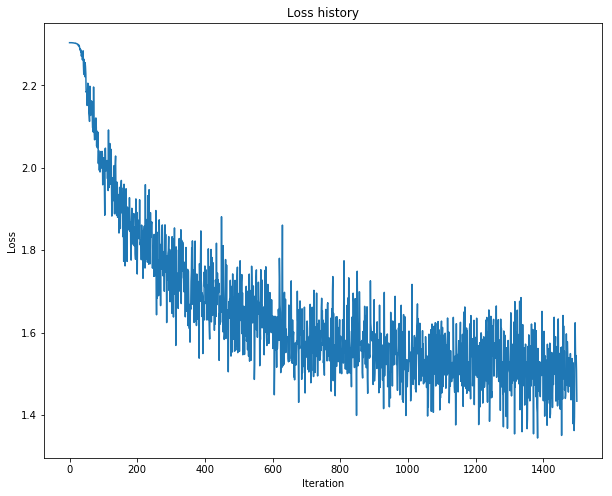

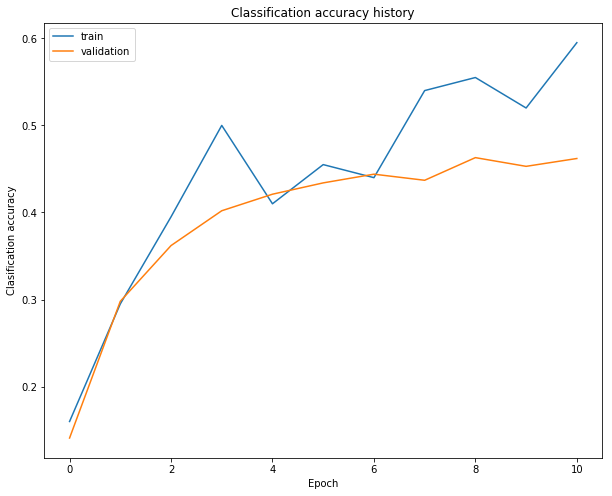

In [9]:
# plot the loss function and train/validation accuracies

plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='validation')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

Visualize the weights of the network

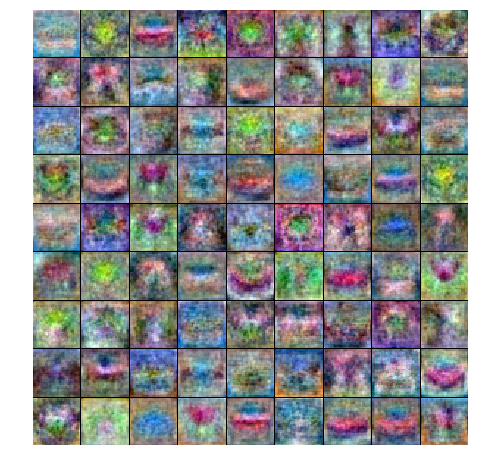

In [10]:
from cs231n.vis_utils import visualize_grid
def show_network_weights(network):
    W1 = network.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=1).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_network_weights(net)

### Change the learning rate decay to a smaller value.

iteration 0 / 1500: loss 2.303818
iteration 100 / 1500: loss 2.002031
iteration 200 / 1500: loss 1.875476
iteration 300 / 1500: loss 1.852365
iteration 400 / 1500: loss 1.780765
iteration 500 / 1500: loss 1.705423
iteration 600 / 1500: loss 1.749224
iteration 700 / 1500: loss 1.730983
iteration 800 / 1500: loss 1.588529
iteration 900 / 1500: loss 1.644010
iteration 1000 / 1500: loss 1.741660
iteration 1100 / 1500: loss 1.576661
iteration 1200 / 1500: loss 1.551222
iteration 1300 / 1500: loss 1.625010
iteration 1400 / 1500: loss 1.579213
Validation accuracy:  0.422


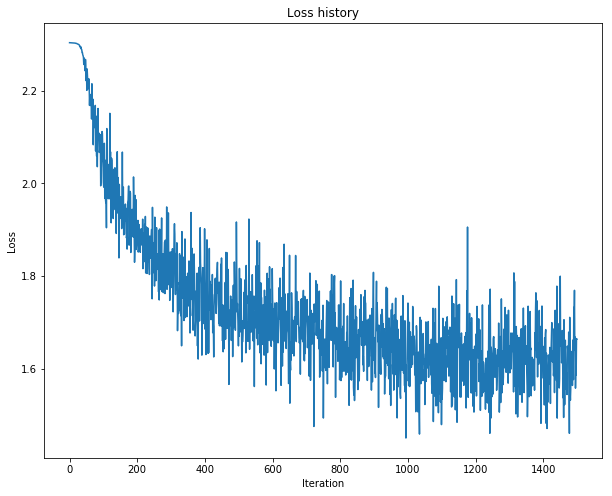

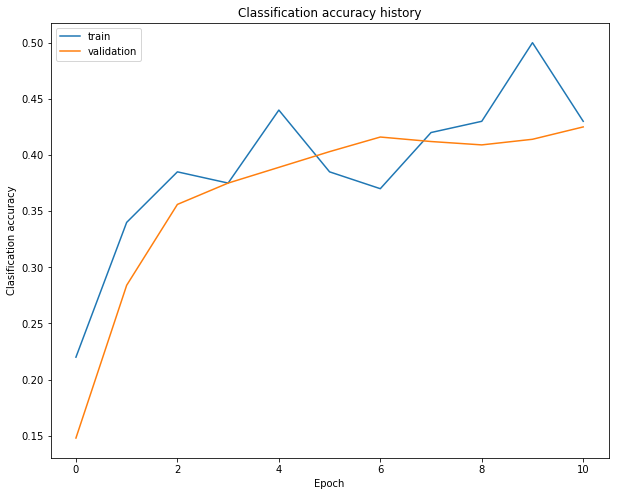

In [11]:
net = TwoLayerNet(input_size, hidden_size, num_classes)   # celar the parameters
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1500,             # Number of steps to take when optimizing
            batch_size=200,             # the number of epoches should be num_iters / (num_train / batch_size)
            learning_rate=7.5e-4, 
            learning_rate_decay=0.8,   # learning rate will be 0.8 times of the previous epoch
            reg=1.0, 
            verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# plot the loss function and train/validation accuracies

plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='validation')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

### Train the network without learning rate decay

iteration 0 / 1500: loss 2.303839
iteration 100 / 1500: loss 2.001846
iteration 200 / 1500: loss 1.826692
iteration 300 / 1500: loss 1.706541
iteration 400 / 1500: loss 1.575614
iteration 500 / 1500: loss 1.571739
iteration 600 / 1500: loss 1.678188
iteration 700 / 1500: loss 1.446129
iteration 800 / 1500: loss 1.672468
iteration 900 / 1500: loss 1.571142
iteration 1000 / 1500: loss 1.503773
iteration 1100 / 1500: loss 1.536674
iteration 1200 / 1500: loss 1.505527
iteration 1300 / 1500: loss 1.543511
iteration 1400 / 1500: loss 1.645679
Validation accuracy:  0.462


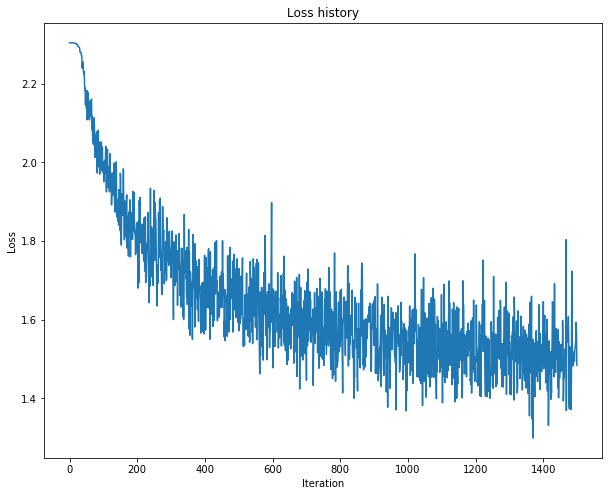

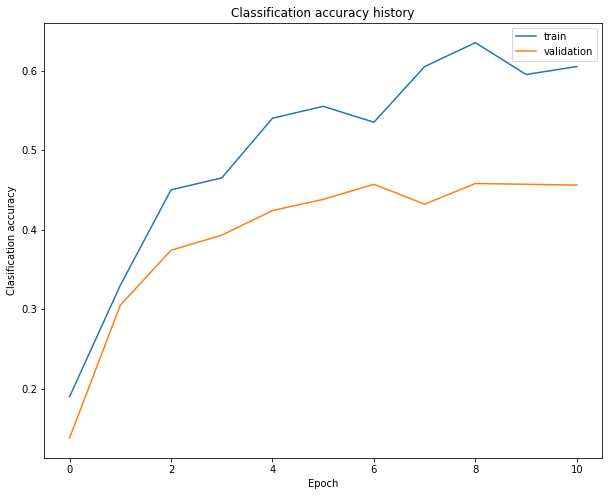

In [12]:
net = TwoLayerNet(input_size, hidden_size, num_classes)   # celar the parameters
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1500,             # Number of steps to take when optimizing
            batch_size=200,             # the number of epoches should be num_iters / (num_train / batch_size)
            learning_rate=7.5e-4, 
            learning_rate_decay=1,   # learning rate will be all the same
            reg=1.0, 
            verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# plot the loss function and train/validation accuracies

plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='validation')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

### Tune the hyperparameters
Tune the hyperparameters using the validation set. Store your best trainedmodel in best_net

In [13]:
hidden_size = 81
best_val = -1
best_Net = None

learning_rate = np.array([2.5, 5, 7.5, 10, 15, 20]) * 1e-4
regularization_strengths = [0.25, 0.5, 0.75, 1, 1.25]

for lr in learning_rate:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        # train the network
        stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=1500, batch_size=200,
                        learning_rate=lr, learning_rate_decay = 0.95,
                        reg = reg, verbose=False)
        val_acc = (net.predict(X_val) == y_val).mean()
        if val_acc > best_val:
            best_val = val_acc
            best_Net = net
        print("Learing rate %e, regularization %e, validation accuracy : %f" % (lr, reg, val_acc))
print("best validation accuracy achieved during cross-validation: %f" % best_val)

Learing rate 2.500000e-04, regularization 2.500000e-01, validation accuracy : 0.407000
Learing rate 2.500000e-04, regularization 5.000000e-01, validation accuracy : 0.412000
Learing rate 2.500000e-04, regularization 7.500000e-01, validation accuracy : 0.396000
Learing rate 2.500000e-04, regularization 1.000000e+00, validation accuracy : 0.400000
Learing rate 2.500000e-04, regularization 1.250000e+00, validation accuracy : 0.407000
Learing rate 5.000000e-04, regularization 2.500000e-01, validation accuracy : 0.456000
Learing rate 5.000000e-04, regularization 5.000000e-01, validation accuracy : 0.447000
Learing rate 5.000000e-04, regularization 7.500000e-01, validation accuracy : 0.439000
Learing rate 5.000000e-04, regularization 1.000000e+00, validation accuracy : 0.444000
Learing rate 5.000000e-04, regularization 1.250000e+00, validation accuracy : 0.438000
Learing rate 7.500000e-04, regularization 2.500000e-01, validation accuracy : 0.466000
Learing rate 7.500000e-04, regularization 5